# Forecasting AI and ML Job Trends

Here, we filter out AI/ML/DS jobs using Keyword Matching

## Dependencies

In [163]:
import re
from collections import Counter
import random
# from tqdm import tqdm
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from joblib import Parallel, delayed
from functools import lru_cache
import scipy.sparse as sp

from IPython.display import display, Markdown

from wordcloud import WordCloud

## Data Loading

In [ ]:
filename = "data/a_job_postings_normalized.parquet"
job_postings = pd.read_parquet(filename)

In [165]:
print(f"{len(job_postings):,} job postings loaded from {filename}")
job_postings.sample(5)

1,296,381 job postings loaded from ../data/a_job_postings_normalized.parquet


,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,skills_count
1294283,2024-01-19 22:41:10.920465+00,t,t,f,cyber security distinguished engineer,jobs for humanity,buffalo-niagara falls area,2024-01-14,west seneca,united states,value engineer,mid senior,onsite,"[software engineering, cybersecurity, aws, gcp...",24
937893,2024-01-21 00:18:00.9254+00,t,t,f,"registered nurse rn - sign-on bonus $7,500 - a...","futurecare associates, inc.","harbor, or",2024-01-14,oregon,united states,nurse-midwife,mid senior,onsite,"[registered nurse, nursing, healthcare, patien...",22
1254514,2024-01-21 06:15:31.467221+00,t,t,f,fitness service manager,gold's gym,"los angeles, ca",2024-01-15,west covina,united states,cooper,mid senior,onsite,"[fitness industry experience, positive attitud...",15
293542,2024-01-19 09:45:09.215838+00,t,t,f,salon manager - river road,jobs for humanity,"puyallup, wa",2024-01-12,puyallup,united states,barber,mid senior,onsite,"[hair cutting, styling, communication, leaders...",9
635709,2024-01-19 09:45:09.215838+00,t,t,f,licensed professional counselor (lpc),gotham enterprises ltd,"galveston, tx",2024-01-13,dickinson,united states,counselor,mid senior,onsite,"[counseling, mental health, cbt, dbt, psychody...",21


## Keyword Likelihood Analysis

Use 150 most common AI/ML job terms

In [166]:
ai_ml_terms = """
    artificial intelligence, machine learning, deep learning, neural networks, \
    computer vision, natural language processing, large language model, \
    reinforcement learning, supervised learning, unsupervised learning, \
    semi-supervised learning, transfer learning, predictive modeling, classification, \
    regression, clustering, convolutional neural networks, cnn, rnn, \
    long short-term memory, lstm, gan, generative adversarial networks, \
    support vector machine, svm, random forests, decision trees, ensemble learning, \
    feature engineering, feature selection, data preprocessing, data mining, big data, \
    data science, data analysis, data visualization, sentiment analysis, chatbots, \
    speech recognition, image recognition, object detection, time series analysis, \
    recommender systems, autonomous systems, robotics, chatbot development, \
    nlp algorithms, tensorFlow, keras, pytorch, scikit-learn, openai, \
    machine learning algorithms, model training, model evaluation
"""

ai_ml_frameworks = """
    Python, R, Julia, SQL, Apache Spark, Databricks, Jupyter Notebook, \
    Google Cloud AI Platform, Amazon SageMaker, Microsoft Azure Machine Learning, \
    Docker, Kubernetes, Git, GitHub, Anaconda, Weights & Biases, MLflow, \
    Apache Kafka, Airflow, Tableau, Power BI, Looker, MATLAB, Scala, C++, Java, \
    PySpark, Databricks, Snowflake, BigQuery, Vertex AI, OpenCV, NLTK, spaCy, \
    Gensim, Hugging Face Transformers, Ray, Dask, Kedro, \
    DVC, Data Version Control, Great Expectations, Kedro, Weights & Biases, \
    Streamlit, FastAPI, Dash, Flask, XGBoost, LightGBM
"""

ai_ml_acronyms = """
    RAG, LLM, GenAI, ML, DL, NLP, CV, RL, GAN, CNN, RNN, LSTM, SVM, SAA, AGI, \
    AIoT, HCI, TF, PyTorch, KNN, SVD, BERT, GPT, T5, VAE, BIM, BOM, IoT, CICD, \
    MLOps, AI/ML, API, RPA, ETL, DNN, RNN, BFS, AIaaS, MLaaS, DLaaS, Jupyter, \
    K8s, EDA, RNN, BERT, VQA, CVPR, MT, FL, AI-ML, Keras, XLNet
"""

ai_ml_keywords = set(map(str.strip, ai_ml_terms.lower().split(","))) | \
                 set(map(str.strip, ai_ml_frameworks.lower().split(","))) | \
                 set(map(str.strip, ai_ml_acronyms.lower().split(",")))

print(f"Number of AI/ML keywords: {len(ai_ml_keywords)}")

Number of AI/ML keywords: 144


Create weighted dictionary for AI/ML keywords

In [167]:
def create_keyword_weights():    
    # Define category weights
    weights = {
        'critical': 2.0,    # Core AI/ML concepts
        'important': 1.5,   # Key tools and frameworks
        'standard': 1.2,    # Common technical terms
        'relevant': 1.0     # Related concepts
    }
    
    # Critical terms - fundamental AI/ML concepts
    critical_terms = {
        'artificial intelligence', 'machine learning', 'deep learning', 
        'neural networks', 'large language model', 'AI/ML', 'AGI',
        'generative adversarial networks', 'natural language processing',
        'computer vision', 'reinforcement learning', 'autonomous systems',
        'supervised learning', 'unsupervised learning', 'transfer learning'
    }

    # Important frameworks/tools - key implementation technologies
    important_tools = {
        'Python', 'TensorFlow', 'PyTorch', 'Keras', 'scikit-learn',
        'Hugging Face Transformers', 'OpenAI', 'Apache Spark', 'Databricks',
        'Google Cloud AI Platform', 'Amazon SageMaker', 'Azure ML',
        'Docker', 'Kubernetes', 'MLflow', 'Ray', 'Weights & Biases',
        'CUDA', 'OpenCV', 'NLTK', 'spaCy', 'FastAPI', 'XGBoost', 'LightGBM'
    }

    # Standard technical terms - common technical concepts
    standard_terms = {
        'NLP', 'CV', 'ML', 'DL', 'CNN', 'RNN', 'LSTM', 'GAN',
        'SVM', 'RAG', 'LLM', 'BERT', 'GPT', 'MLOps',
        'feature engineering', 'data preprocessing', 'model training',
        'data mining', 'big data', 'data science', 'time series analysis',
        'sentiment analysis', 'object detection', 'speech recognition',
        'classification', 'regression', 'clustering', 'ensemble learning'
    }
    
    # Weighted dictionary
    keyword_weights = {}
    
    # Assign weights based on category
    for keyword in ai_ml_keywords:
        keyword_lower = keyword.lower()
        
        if keyword_lower in critical_terms:
            keyword_weights[keyword] = weights['critical']
        elif keyword_lower in important_tools:
            keyword_weights[keyword] = weights['important']
        elif keyword_lower in standard_terms:
            keyword_weights[keyword] = weights['standard']
        else:
            keyword_weights[keyword] = weights['relevant']
            
        # Boost weights for frameworks
        if keyword in ai_ml_frameworks:
            keyword_weights[keyword] *= 1.2
            
        # Boost weights for acronyms (often used in job postings)
        if keyword in ai_ml_acronyms:
            keyword_weights[keyword] *= 1.1
    
    return keyword_weights

Choose 10 random samples from the keyword weights

In [172]:
keyword_weights = create_keyword_weights()

random_sample_weights = random.sample(list(keyword_weights.items()), 10)

print("Random sample weights:")
for keyword, weight in random_sample_weights:
    print(f"{keyword}: {weight}")

Random sample weights:
github: 1.0
dash: 1.0
computer vision: 2.0
flask: 1.0
cicd: 1.0
transfer learning: 2.0
sql: 1.0
llm: 1.0
knn: 1.0
openai: 1.0


Score keyword based on its context/position

In [176]:
def combine_row_text(row):
    return f"""
        {row['job_title']} 
        {row['search_position']} 
        {row['company']} 
        {', '.join(row['job_skills'])}
    """.strip().lower()

Compute weighted and contextual job posting scores

In [ ]:
class WeightedScoreCalculator:
    def __init__(self, ai_ml_keywords, keyword_weights):
        self.ai_ml_keywords = ai_ml_keywords
        self.keyword_weights = keyword_weights
        self.patterns = {
            keyword: re.compile(r"\b" + re.escape(keyword.lower()) + r"\b")
            for keyword in ai_ml_keywords
        }
        self.tfidf_vectorizer = TfidfVectorizer(
            vocabulary=ai_ml_keywords, lowercase=True, dtype=np.float32
        )

    def compute_weighted_scores(self, df):
        """Compute weighted scores for all job postings."""
        print("Starting weighted score computation...")
        df = df.copy()

        # Combine text for analysis
        print("Combining text...")
        df["combined_text"] = df.apply(combine_row_text, axis=1)

        # Compute TF-IDF scores
        print("Computing TF-IDF scores...")
        tfidf_matrix = self.tfidf_vectorizer.fit_transform(df["combined_text"])
        tfidf_scores = tfidf_matrix.toarray()

        # Compute scores in parallel
        print("Calculating scores...")
        scores = Parallel(n_jobs=-1)(
            delayed(self._calculate_row_score)(text, tfidf_scores[idx])
            for idx, text in enumerate(
                tqdm(df["combined_text"], desc="Processing job descriptions")
            )
        )

        df["weighted_score"] = scores
        
        print("Computation complete.")
        return df

    def _calculate_row_score(self, text, tfidf_row):
        """Compute the weighted score for a single row."""
        base_score, max_possible = 0, 0

        for keyword, pattern in self.patterns.items():
            weight = self.keyword_weights[keyword]
            tfidf = tfidf_row[list(self.patterns.keys()).index(keyword)]
            context_score = self._compute_contextual_score(text, pattern)
            base_score += weight * (tfidf + context_score)
            max_possible += weight * 3  # Max score: TF-IDF (1) + Context (2)

        return min(100, int((base_score / max_possible) * 100)) if max_possible else 0

    @staticmethod
    def _compute_contextual_score(text, pattern):
        """Compute contextual score for a keyword."""
        text_lower = text.lower()
        score = 0
        if pattern.search(text_lower[:200]):
            score += 2.0
        if "required" in text_lower and pattern.search(text_lower):
            score += 1.5
        if "preferred" in text_lower and pattern.search(text_lower):
            score += 1.0
        return score

In [ ]:
calculator = WeightedScoreCalculator(ai_ml_keywords, keyword_weights)

scored_jobs = calculator.compute_weighted_scores(job_postings)

Starting weighted score computation...
Combining text...
Computing TF-IDF scores...
Calculating scores...


Processing job descriptions:   0%|          | 0/1296381 [00:00<?, ?it/s]

Computation complete.


In [185]:
ai_ml_job_postings = scored_jobs[scored_jobs['weighted_score'] > 0]
print(f"Number of potential AI/ML jobs: {len(ai_ml_job_postings):,}")

print(f"\nAverage weighted score for AI/ML jobs: {ai_ml_job_postings['weighted_score'].mean():.2f}")
print("\nTop 10 scoring jobs:")
print(ai_ml_job_postings.nlargest(10, 'weighted_score')[['job_title', 'weighted_score']])

Number of potential AI/ML jobs: 21,976

Average weighted score for AI/ML jobs: 1.34

Top 10 scoring jobs:
                                                 job_title  weighted_score
1005741                         director, applied research              10
91438    senior manager, artificial intelligence [bell ...               9
886956   senior data scientist ai/ml- insurance domain ...               9
1017667  data analyst, junior - security clearance requ...               7
60651           senior data scientist - clearance required               6
179763   sr. data scientist for signal processing proje...               6
253602                                intelligence analyst               6
361551                                      data scientist               6
381335                            sr. data engineer (pasa)               6
452446     spatial data scientist (active ts/sci required)               6


## Keyword Analysis

Filter the job postings based on the weighted score

In [186]:
def filter_by_weighted_score(df, threshold=0):
    df = df.copy()
    return df[df["weighted_score"] >= threshold]

Plot the distribution of keyword likelihood across job postings.

In [187]:
def plot_weighted_score_distribution(df, threshold=0):    
    distribution =  df["weighted_score"].value_counts().sort_index()
    print(distribution)

    plt.figure(figsize=(8, 5))
    distribution.plot(kind="bar", color="blue", alpha=0.7)
    plt.title(f"Distribution of Weighted Scores (Threshold: {threshold})")
    plt.xlabel("Weighted Score")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.show()

Perform frequency analysis of AI-related skills across job postings.

In [188]:
def frequency_analysis_of_skills(df):
    all_skills = [skill.lower() for skills in df["job_skills"] for skill in skills]
    return Counter(all_skills)

Plot the top N AI and ML skills in demand.

In [189]:
def visualize_skill_demand(df, top_n=20, min_weighted_score=0):
    title = (
        f"Top {top_n} AI and ML Skills in Demand (Weighted Score > {min_weighted_score})"
        if min_weighted_score > 0
        else f"Top {top_n} AI and ML Skills in Demand"
    )
    filtered_df = df[df["weighted_score"] > min_weighted_score]
    all_skills = [skill for sublist in filtered_df["job_skills"] for skill in sublist]
    skill_counts = Counter(all_skills)

    top_k_skills = skill_counts.most_common(top_n)
    skills, counts = zip(*top_k_skills)

    plt.figure(figsize=(8, 6))
    plt.barh(skills, counts, color="blue", alpha=0.9)
    plt.title(title)
    plt.xlabel("Number of Job Postings")
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.show()

Create a word cloud visualization of popular AI skills

In [190]:
def create_word_cloud(df):
    skill_counts = frequency_analysis_of_skills(df)

    wordcloud = WordCloud(
        width=800, height=400, background_color="white"
    ).generate_from_frequencies(skill_counts)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [191]:
def analyze_jobs(df, min_weighted_score=0):
    filtered_jobs = filter_by_weighted_score(df, threshold=min_weighted_score)

    display(
        Markdown(
            f"### **Keyword Analysis for Minimum Weighted Score of {min_weighted_score}**"
        )
    )
    display(
        Markdown(
            f"Percentage of jobs with at least {min_weighted_score} weighted score: **{filtered_jobs.shape[0] / job_postings.shape[0]:.2%}**"
        )
    )
    display(
        Markdown(
            f"Number of jobs with at least {min_weighted_score} weighted score: **{filtered_jobs.shape[0]:,}**"
        )
    )

    plot_weighted_score_distribution(filtered_jobs, threshold=min_weighted_score)

    visualize_skill_demand(
        filtered_jobs, top_n=20, min_weighted_score=min_weighted_score
    )

    create_word_cloud(filtered_jobs)

### **Keyword Analysis for Minimum Weighted Score of 0**

Percentage of jobs with at least 0 weighted score: **1.70%**

Number of jobs with at least 0 weighted score: **21,976**

weighted_score
1     16097
2      4673
3       946
4       221
5        23
6        12
7         1
9         2
10        1
Name: count, dtype: int64


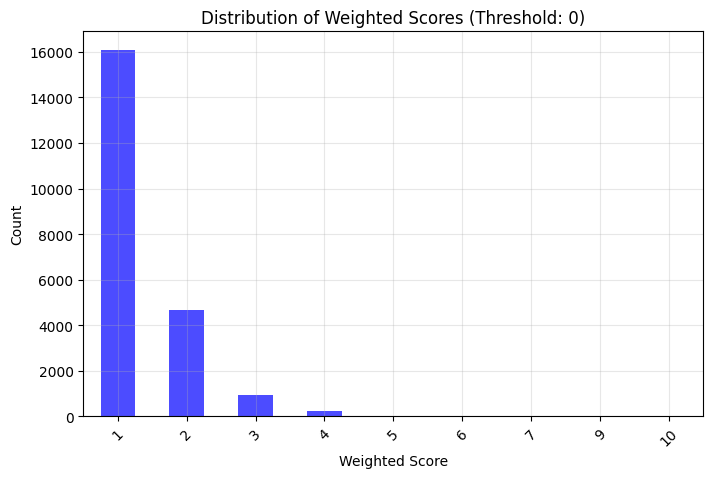

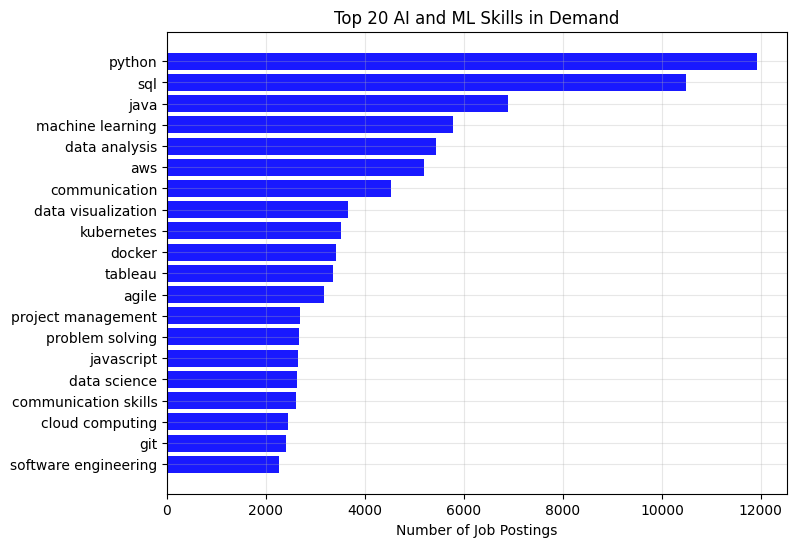

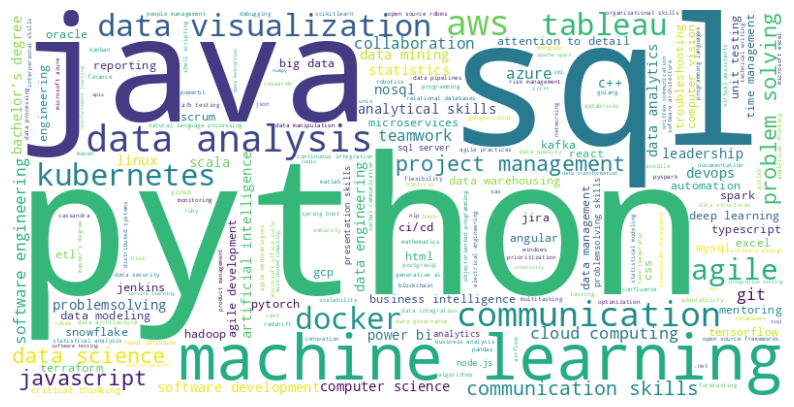

In [192]:
analyze_jobs(ai_ml_job_postings, min_weighted_score=0)

### **Keyword Analysis for Minimum Weighted Score of 4**

Percentage of jobs with at least 4 weighted score: **0.02%**

Number of jobs with at least 4 weighted score: **260**

weighted_score
4     221
5      23
6      12
7       1
9       2
10      1
Name: count, dtype: int64


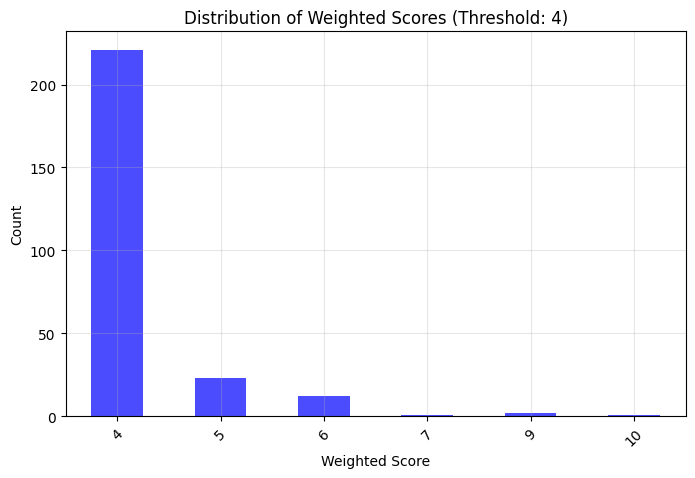

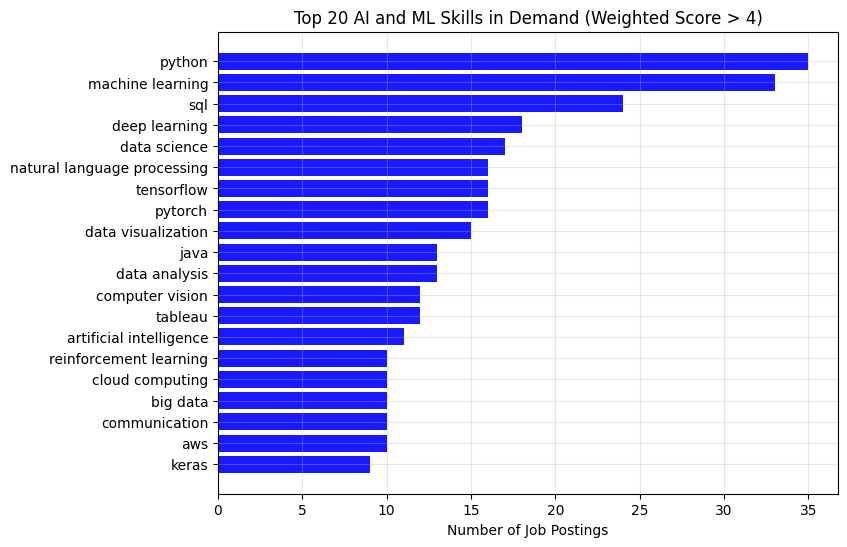

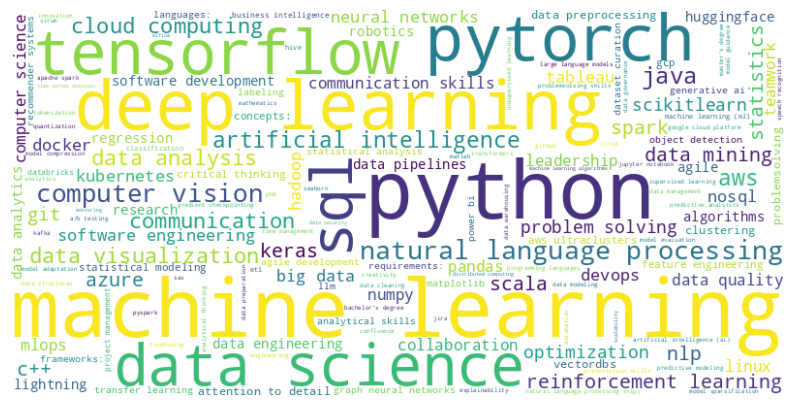

In [193]:
analyze_jobs(ai_ml_job_postings, min_weighted_score=4)

## Labelling

In [197]:
def append_labels(df, threshold=0):
    df["label"] = (df["weighted_score"] > threshold).astype(int)
    labeled_df = df[["combined_text", "label"]].rename(
        columns={"combined_text": "job_description"}
    )
    return labeled_df

In [198]:
threshold = 0
labelled_dataset = append_labels(scored_jobs, threshold)

labelled_dataset["label"].value_counts()

labelled_dataset.sample(5)

,job_description,label
244533,home health occupational therapy assistant ota...,0
302582,customer service representative \n bus ...,0
916129,partner support manager \n manager prom...,0
928966,veterinary surgeon \n zoo veterinarian ...,0
1246412,hair stylist - shops at round lake \n p...,0


## Save dataset
Save the labelled job postings with labels

In [ ]:
filename = "data/b_job_postings_labelled.parquet"
labelled_dataset.to_parquet(filename, index=False)

print(f"Data with labels saved to {filename}")

Data with labels saved to ../data/b_job_postings_labelled.parquet
